<a href="https://colab.research.google.com/github/IbrahimAllMamun/flood_incidence/blob/main/flood_incidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf


from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics, Input, Model


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
!wget https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv

--2025-09-16 15:50:03--  https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071590 (2.0M) [text/plain]
Saving to: ‘flood.csv’

flood.csv           100%[===================>]   1.98M  --.-KB/s    in 0.01s   

2025-09-16 15:50:03 (197 MB/s) - ‘flood.csv’ saved [2071590/2071590]



In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [4]:
df = pd.read_csv('flood.csv')
df.rename(columns={'Flood?':'Flood'}, inplace=True)
df = df.sort_values(["Year", "Month", "Station_Number"])
df.drop(columns=['Sl', 'LATITUDE', 'LONGITUDE', 'Period'], inplace=True)
df.fillna({'Flood':0}, inplace=True)
display(df.head())

,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,ALT,Flood
5892,Dinajpur,1948,1,28.9,10.4,0.000000,60.00000,0.624074,1.3,5.572000,41863,365790.2,834718.0,37,0.0
1356,Bogra,1948,1,25.8,11.7,8.140625,74.21875,0.875926,1.1,7.296226,41883,435303.7,751187.5,20,0.0
13188,Mymensingh,1948,1,28.3,11.7,0.000000,67.00000,0.594444,1.7,6.134286,41886,540975.3,737535.8,19,0.0
18288,Srimangal,1948,1,27.7,9.0,8.015385,75.00000,0.464815,2.4,6.710714,41915,675761.6,687095.9,23,0.0
6684,Faridpur,1948,1,27.8,11.9,3.000000,91.00000,0.746296,2.9,6.986207,41929,483877.3,610719.3,9,0.0


In [5]:
# df = df[df['Station_Names'] != "Chittagong (City-Ambagan)"]
# display(df.head())
# print(df.shape)

In [6]:
df.shape

(20544, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20544 entries, 5892 to 20543
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Station_Names      20544 non-null  object 
 1   Year               20544 non-null  int64  
 2   Month              20544 non-null  int64  
 3   Max_Temp           20544 non-null  float64
 4   Min_Temp           20544 non-null  float64
 5   Rainfall           20544 non-null  float64
 6   Relative_Humidity  20544 non-null  float64
 7   Wind_Speed         20544 non-null  float64
 8   Cloud_Coverage     20544 non-null  float64
 9   Bright_Sunshine    20544 non-null  float64
 10  Station_Number     20544 non-null  int64  
 11  X_COR              20544 non-null  float64
 12  Y_COR              20544 non-null  float64
 13  ALT                20544 non-null  int64  
 14  Flood              20544 non-null  float64
dtypes: float64(10), int64(4), object(1)
memory usage: 2.5+ MB


In [8]:
df["Month_sin"] = np.sin(2 * np.pi * (df["Month"] - 1) / 12.0)
df["Month_cos"] = np.cos(2 * np.pi * (df["Month"] - 1) / 12.0)

In [9]:
df['Time'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
display(df.head())

,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,ALT,Flood,Month_sin,Month_cos,Time
5892,Dinajpur,1948,1,28.9,10.4,0.000000,60.00000,0.624074,1.3,5.572000,41863,365790.2,834718.0,37,0.0,0.0,1.0,1948-01-01
1356,Bogra,1948,1,25.8,11.7,8.140625,74.21875,0.875926,1.1,7.296226,41883,435303.7,751187.5,20,0.0,0.0,1.0,1948-01-01
13188,Mymensingh,1948,1,28.3,11.7,0.000000,67.00000,0.594444,1.7,6.134286,41886,540975.3,737535.8,19,0.0,0.0,1.0,1948-01-01
18288,Srimangal,1948,1,27.7,9.0,8.015385,75.00000,0.464815,2.4,6.710714,41915,675761.6,687095.9,23,0.0,0.0,1.0,1948-01-01
6684,Faridpur,1948,1,27.8,11.9,3.000000,91.00000,0.746296,2.9,6.986207,41929,483877.3,610719.3,9,0.0,0.0,1.0,1948-01-01


In [10]:
time_varying = [
    "Max_Temp", "Min_Temp", "Rainfall", "Relative_Humidity",
    "Wind_Speed", "Cloud_Coverage", "Bright_Sunshine",
    "Month_sin", "Month_cos"
]
static_feats = ["ALT", "X_COR", "Y_COR"]

In [11]:
def build_sequences_monthly(df, window=12):
    X_seq, X_static, y, groups = [], [], [], []

    for st, g in df.groupby("Station_Number"):
        g = g.sort_values(["Year", "Month"])   # continuous timeline per station

        seq_data = g[time_varying].to_numpy(dtype=float)
        static_vals = g[static_feats].iloc[0].to_numpy(dtype=float)
        labels = g["Flood"].to_numpy(dtype=int)
        years = g["Year"].to_numpy()
        months = g["Month"].to_numpy()

        for i in range(len(g) - window):
            X_seq.append(seq_data[i:i+window])
            X_static.append(static_vals)
            y.append(labels[i+window])  # predict flood in next month
            groups.append((st, years[i+window], months[i+window]))

    return (
        np.array(X_seq),
        np.array(X_static),
        np.array(y).astype(int),
        pd.DataFrame(groups, columns=["Station_Number", "Year", "Month"])
    )


# Example
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", X_seq.shape)   # (N, 12, n_features)
print("Static:", X_static.shape)   # (N, 3)
print("Labels:", y.shape)          # (N,)
print("Positives:", y.sum(), "Negatives:", (y==0).sum())


Sequences: (20148, 12, 9)
Static: (20148, 3)
Labels: (20148,)
Positives: 4048 Negatives: 16100


In [12]:
groups

,Station_Number,Year,Month
0,41859,1955,1
1,41859,1955,2
2,41859,1955,3
3,41859,1955,4
4,41859,1955,5
...,...,...,...
20143,41998,2013,8
20144,41998,2013,9
20145,41998,2013,10
20146,41998,2013,11


In [13]:
from sklearn.model_selection import train_test_split

def scale_data(X_seq, X_sta):
    Ntr, T, F = X_seq.shape

    seq_scaler = StandardScaler()
    sta_scaler = StandardScaler()

    Xseq = seq_scaler.fit_transform(X_seq.reshape(-1, F)).reshape(Ntr, T, F)
    Xsta  = sta_scaler.fit_transform(X_sta)

    return Xseq, Xsta


# Build sequences first
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)

X_seq, X_static = scale_data(X_seq, X_static)

# Choose cutoff year
cutoff_year_val = 1995
cutoff_year_test = 2004

train_idx = groups["Year"] <= cutoff_year_val
val_idx = (groups["Year"] > cutoff_year_val) & (groups["Year"] < cutoff_year_test)

ftrain_idx = groups["Year"] <= cutoff_year_test
test_idx  = groups["Year"] > cutoff_year_test


fXseq_tr_s, Xseq_tr_s, Xseq_val_s, Xseq_te_s = X_seq[ftrain_idx], X_seq[train_idx], X_seq[val_idx] , X_seq[test_idx]
fXs_tr_s, Xs_tr_s, Xs_val_s, Xs_te_s = X_static[ftrain_idx], X_static[train_idx], X_static[val_idx] , X_static[test_idx]
fy_train, y_train, y_val , y_test = y[ftrain_idx], y[train_idx], y[val_idx] , y[test_idx]
fgroups_train, groups_train, groups_val, groups_test = groups[ftrain_idx], groups[train_idx], groups[val_idx] , groups[test_idx]

print("Train:", Xseq_tr_s.shape, "Positives:", y_train.sum())
print("Validation :", Xseq_val_s.shape, "Positives:", y_val.sum())

print("Final Training :", fXseq_tr_s.shape, "Positives:", fy_train.sum())
print("Test :", Xseq_te_s.shape, "Positives:", y_test.sum())

Train: (13200, 12, 9) Positives: 2554
Validation : (3072, 12, 9) Positives: 656
Final Training : (16656, 12, 9) Positives: 3308
Test : (3492, 12, 9) Positives: 740


In [14]:
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", Xseq_tr_s.shape)   # (N, 12, n_features)
print("Static:", Xs_tr_s.shape)   # (N, 3)

Sequences: (13200, 12, 9)
Static: (13200, 3)


In [16]:
def make_model(n_steps, n_seq_feats, n_static_feats, lstm_units=(64, 32), dense_units=32, dropout=0.2, optimizer="Adam", lr=1e-3, threshold=0.5, alpha=0.01):
    seq_in = Input(shape=(n_steps, n_seq_feats), name="seq_in")
    x = seq_in
    # LSTM stack
    x = layers.LSTM(lstm_units[0], return_sequences=True)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(lstm_units[1])(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense_units)(x)
    x = layers.LeakyReLU(alpha=alpha)(x)


    inputs = [seq_in]
    # static tower
    if n_static_feats > 0:
        sta_in = Input(shape=(n_static_feats,), name="static_in")
        s = layers.Dense(32)(sta_in)
        s = layers.LeakyReLU(alpha=alpha)(s)
        # s = layers.Dense(32)(s)
        # s = layers.LeakyReLU(alpha=0.01)(s)
        # s = layers.Dense(32)(s)
        # s = layers.LeakyReLU(alpha=0.01)(s)
        s = layers.Dropout(dropout)(s)
        x = layers.Concatenate()([x, s])
        inputs.append(sta_in)

    x = layers.Dense(dense_units)(x)
    x = layers.LeakyReLU(alpha=alpha)(x)
    x = layers.Dense(dense_units*2)(x)
    x = layers.LeakyReLU(alpha=alpha)(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(
        optimizer=optimizers.SGD(learning_rate=lr) if optimizer=="SGD" else optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            metrics.AUC(curve="ROC", name="auc_roc"),
            metrics.AUC(curve="PR",  name="auc_pr"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.BinaryAccuracy(name="accuracy", threshold=threshold)
        ],
    )

    return model

Ntr, T, F = Xseq_tr_s.shape

model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=Xs_tr_s.shape[1],
    lstm_units=(64, 32),
    dense_units=32,
    dropout=0.2,
    optimizer="Adam",
    lr=1e-3,
    threshold=0.7,
    alpha=0.01
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 12, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     18,944 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 12, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │     12,416 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        128 │ static_in[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      1,056 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 32)        │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32)        │          0 │ dense[0][0]       │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ leaky_re_lu[0][0… │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 32)        │          0 │ dense_2[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,112 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 64)        │          0 │ dense_3[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         65 │ leaky_re_lu_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,801 (143.75 KB)

 Trainable params: 36,801 (143.75 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# -----------------------
# 7) Class weights for imbalance
# -----------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = neg / max(pos, 1)
class_weight = {0: 1.0, 1: float(pos_weight)}
print("Class weights:", class_weight)

Class weights: {0: 1.0, 1: 4.168363351605325}


In [92]:
# -----------------------
# 8) Train
# -----------------------
es = callbacks.EarlyStopping(
    monitor="val_accuracy", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=50,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8181 - auc_pr: 0.5076 - auc_roc: 0.8127 - loss: 0.8732 - precision: 0.4291 - recall: 0.7322 - val_accuracy: 0.8395 - val_auc_pr: 0.7646 - val_auc_roc: 0.9231 - val_loss: 0.3778 - val_precision: 0.5219 - val_recall: 0.9101
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8428 - auc_pr: 0.7088 - auc_roc: 0.9169 - loss: 0.5716 - precision: 0.4813 - recall: 0.9079 - val_accuracy: 0.8421 - val_auc_pr: 0.7852 - val_auc_roc: 0.9290 - val_loss: 0.3782 - val_precision: 0.5290 - val_recall: 0.9177
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.8650 - auc_pr: 0.7273 - auc_roc: 0.9261 - loss: 0.5412 - precision: 0.5037 - recall: 0.8999 - val_accuracy: 0.8590 - val_auc_pr: 0.7892 - val_auc_roc: 0.9307 - val_loss: 0.3554 - val_precision: 0.5473 - val_recall: 0.8994
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8718 - auc_pr: 0.7401 - auc_roc: 0.9299 - loss: 0.5239 - precisio

In [93]:
# -----------------------
# 9) Threshold tuning on validation
# -----------------------
val_probs = model.predict([Xseq_val_s, Xs_val_s]).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)



96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Best threshold (F1 on val): 0.5973634


In [94]:
# -----------------------
# 10) Final evaluation on test
# -----------------------
from sklearn.metrics import accuracy_score

test_probs = model.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
ROC-AUC: 0.9150342748271527
PR-AUC: 0.7263191327788765
Accuracy: 0.8419243986254296
Confusion matrix:
 [[2374  378]
 [ 174  566]]
              precision    recall  f1-score   support

           0      0.932     0.863     0.896      2752
           1      0.600     0.765     0.672       740

    accuracy                          0.842      3492
   macro avg      0.766     0.814     0.784      3492
weighted avg      0.861     0.842     0.848      3492



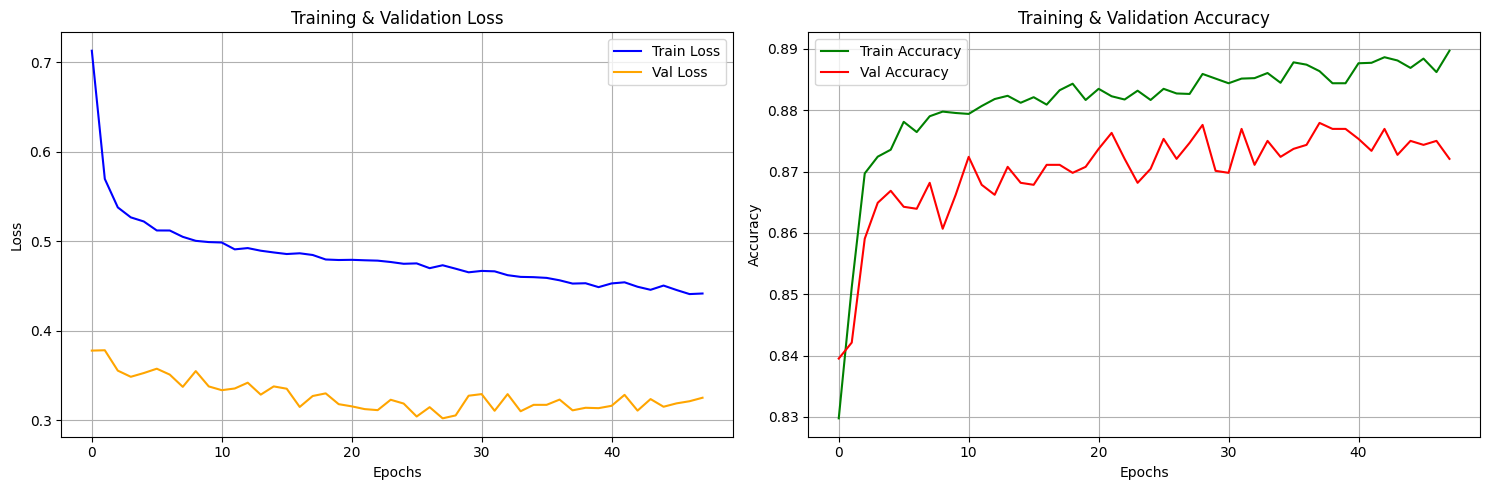

In [95]:
# -----------------------
# 9) Plot Training Curves
# -----------------------
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# --------- Loss subplot ---------
axs[0].plot(history.history["loss"], label="Train Loss", color='blue')
axs[0].plot(history.history["val_loss"], label="Val Loss", color='orange')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training & Validation Loss")
axs[0].legend()
axs[0].grid(True)

# --------- Accuracy subplot (if exists) ---------
axs[1].plot(history.history["accuracy"], label="Train Accuracy", color='green')
axs[1].plot(history.history["val_accuracy"], label="Val Accuracy", color='red')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training & Validation Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


```
model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=Xs_tr_s.shape[1],
    lstm_units=(64, 32),
    dense_units=32,
    dropout=0.3,
    lr=1e-3
)

# -----------------------
# 8) Train
# -----------------------
es = callbacks.EarlyStopping(
    monitor="val_accuracy", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=200,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)



Best threshold (F1 on val): 0.71895254

ROC-AUC: 0.9160089381070019
PR-AUC: 0.7394622780049686
Accuracy: 0.864519427402863
Confusion matrix:
 [[1401  158]
 [ 107  290]]
              precision    recall  f1-score   support

           0      0.929     0.899     0.914      1559
           1      0.647     0.730     0.686       397

    accuracy                          0.865      1956
   macro avg      0.788     0.815     0.800      1956
weighted avg      0.872     0.865     0.867      1956
```

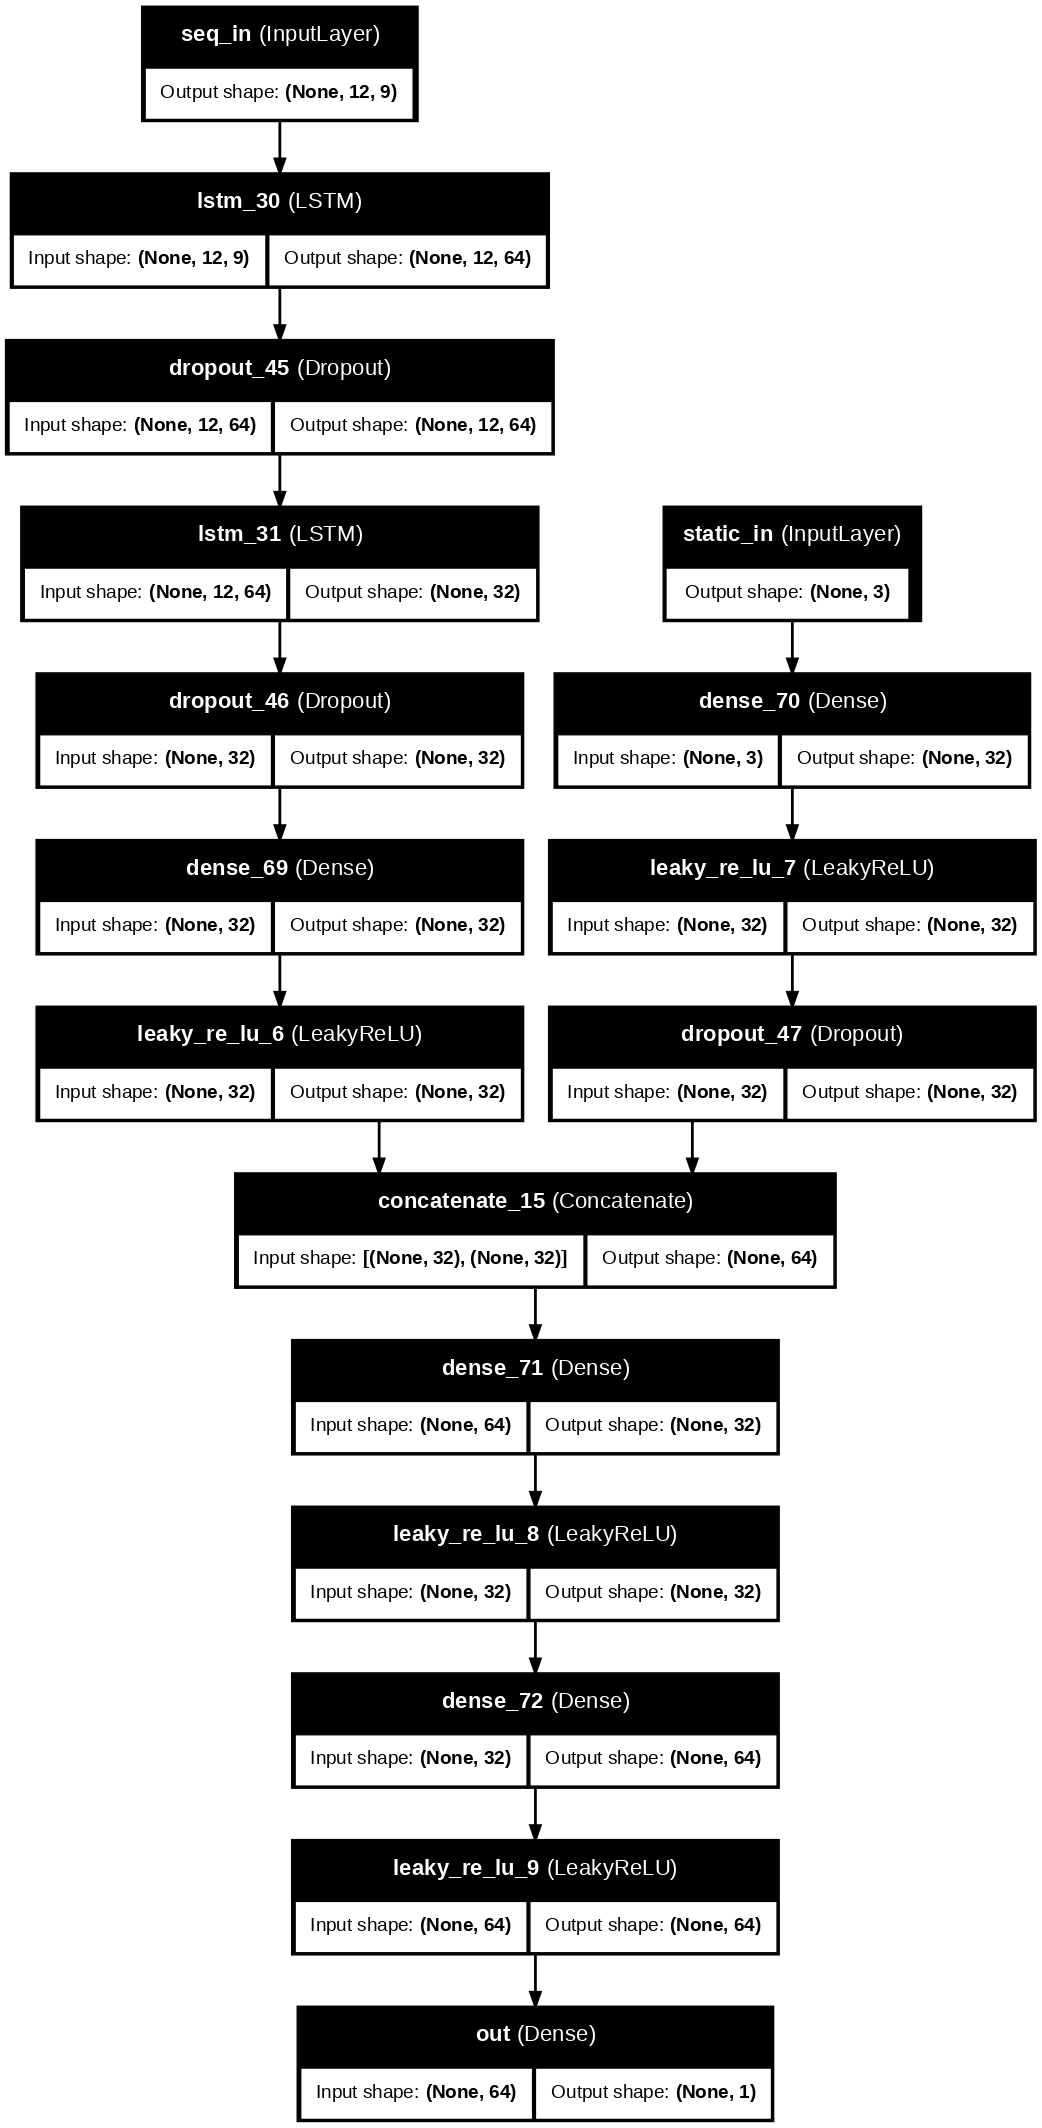

In [97]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(
    model,
    to_file="model_diagram.png",  # output file
    show_shapes=True,             # show tensor shapes
    show_layer_names=True,        # show layer names
    expand_nested=False,
    dpi=100
)


In [ ]:
model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=Xs_tr_s.shape[1],
    lstm_units=(64, 32),
    dense_units=32,
    dropout=0.3,
    lr=1e-3
)
es = callbacks.EarlyStopping(
    monitor="val_accuracy", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=200,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

In [ ]:
# 1) Define the hyperparameter grid
param_grid = {
    'lstm_units': [(64, 32), (128, 64)],
    'dense_units': [32, 64],
    'dropout': [0.2, 0.3, 0.4],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [50, 100],
    'optimizer': ['adam', 'sgd']

}

# 2) Set up time-aware cross-validation using GroupShuffleSplit
# We use GroupShuffleSplit to ensure that samples from the same Station_Number/Year/Month
# combination are not split across training and validation sets within a fold.
# We'll perform splits based on the 'groups' DataFrame which contains Station_Number, Year, and Month.
# The time-aware aspect is handled by the train/validation/test splits based on Year earlier.
# Here, we split the training data (pre-cutoff_year_val) for cross-validation.
# We need to combine the training and validation sets from the previous split for CV.

# Combine train and validation data for CV
X_seq_train_val = np.concatenate((Xseq_tr_s, Xseq_val_s), axis=0)
X_static_train_val = np.concatenate((Xs_tr_s, Xs_val_s), axis=0)
y_train_val = np.concatenate((y_train, y_val), axis=0)
groups_train_val = pd.concat((groups_train, groups_val), axis=0)


gss = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=RANDOM_STATE)

# Iterate through the grid and folds
results = []

for lstm_u, dense_u, dp, learn_r in [(lstm_u, dense_u, dp, learn_r)
                                      for lstm_u in param_grid['lstm_units']
                                      for dense_u in param_grid['dense_units']
                                      for dp in param_grid['dropout']
                                      for learn_r in param_grid['lr']]:

    print(f"\nTesting: lstm_units={lstm_u}, dense_units={dense_u}, dropout={dp}, lr={learn_r}")
    fold_results = []

    for fold, (train_idx_cv, val_idx_cv) in enumerate(gss.split(X_seq_train_val, y_train_val, groups=groups_train_val['Station_Number'])):
        print(f"  Fold {fold+1}:")

        # Split data for the current fold
        X_seq_train_cv, X_seq_val_cv = X_seq_train_val[train_idx_cv], X_seq_train_val[val_idx_cv]
        X_static_train_cv, X_static_val_cv = X_static_train_val[train_idx_cv], X_static_train_val[val_idx_cv]
        y_train_cv, y_val_cv = y_train_val[train_idx_cv], y_train_val[val_idx_cv]

        # (Steps 4 and 5 will be added in subsequent responses: Train and evaluate the model)
        # For now, we'll just print the shapes to show the split is working
        print(f"    Train CV shapes: X_seq={X_seq_train_cv.shape}, X_static={X_static_train_cv.shape}, y={y_train_cv.shape}")
        print(f"    Val CV shapes: X_seq={X_seq_val_cv.shape}, X_static={X_static_val_cv.shape}, y={y_val_cv.shape}")

In [28]:
param_grid = {
    'lstm_units': [(64, 32), (128, 64)],
    'dense_units': [32, 64],
    'dropout': [0.2, 0.3],
    'batch_size': [32, 64]
    }

In [29]:
from itertools import product

best_score = -np.inf
best_params = None
best_model  = None

for lstm_units, dense_units, dropout, batch_size in product(
    param_grid['lstm_units'],
    param_grid['dense_units'],
    param_grid['dropout'],
    param_grid['batch_size']
):
    print(f"Training with: lstm={lstm_units}, dense={dense_units}, "
          f"dropout={dropout}, batch={batch_size}"
          )

    # 1) Build model
    model = make_model(
        n_steps=T,
        n_seq_feats=F,
        n_static_feats=Xs_tr_s.shape[1],
        lstm_units=lstm_units,
        dense_units=dense_units,
        dropout=dropout,
        optimizer='Adam',
        lr=1e-3,
        threshold=0.6
    )

    # 2) Early stopping
    es = callbacks.EarlyStopping(
        monitor='val_auc_pr',   # <-- use PR-AUC or Recall instead of accuracy
        mode="max",
        patience=10,
        restore_best_weights=True
    )

    # 3) Train
    history = model.fit(
        x=[Xseq_tr_s, Xs_tr_s],
        y=y_train,
        validation_data=([Xseq_val_s, Xs_val_s], y_val),
        epochs=100,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=[es],
        verbose=0
    )

    # 4) Evaluate on validation set
    val_probs = model.predict([Xseq_val_s, Xs_val_s]).ravel()
    pr_auc = average_precision_score(y_val, val_probs)

    print(f"Validation PR-AUC = {pr_auc:.4f}")

    # 5) Save best
    if pr_auc > best_score:
        best_score = pr_auc
        best_params = (lstm_units, dense_units, dropout, lr, batch_size, optimizer)
        best_model = model


Training with: lstm=(64, 32), dense=32, dropout=0.2, batch=32
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7929
Training with: lstm=(64, 32), dense=32, dropout=0.2, batch=64
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7957
Training with: lstm=(64, 32), dense=32, dropout=0.3, batch=32
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7885
Training with: lstm=(64, 32), dense=32, dropout=0.3, batch=64
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7958
Training with: lstm=(64, 32), dense=64, dropout=0.2, batch=32
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7926
Training with: lstm=(64, 32), dense=64, dropout=0.2, batch=64
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7913
Training with: lstm=(64, 32), dense=64, dropout=0.3, batch=32
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation PR-AUC = 0.7970
Training with: lstm=(64, 32), dense=64, dropout=0.3, batch=64
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Val

In [19]:
print("Best params:", best_params)
print("Best PR-AUC:", best_score)


test_probs = best_model.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print(classification_report(y_test, test_pred, digits=3))


KeyboardInterrupt: 